In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# サンプルデータ（訓練データ）生成
def makeData(N=1000):
    # 円1：中心 (0.35, 0.35), 半径 0.3 の円
    x1 = 0.35; y1 = 0.35; r1 = 0.3
    # 円2：中心 (0.65, 0.65), 半径 0.3 の円
    x2 = 0.65; y2 = 0.65; r2 = 0.3
    data = np.random.rand(N, 2)
    # 円1 と 円2 どちらかに（のみ）入っているならば 1、そうでなければ 0
    chk1 = np.less_equal(np.linalg.norm(data - np.array([x1, y1]), axis=1), r1)
    chk2 = np.less_equal(np.linalg.norm(data - np.array([x2, y2]), axis=1), r2)
    labels = np.where(np.logical_xor(chk1, chk2), 1, 0)
    return np.hstack([data, labels.reshape((N, 1))])

In [3]:
data = makeData(N=1000)

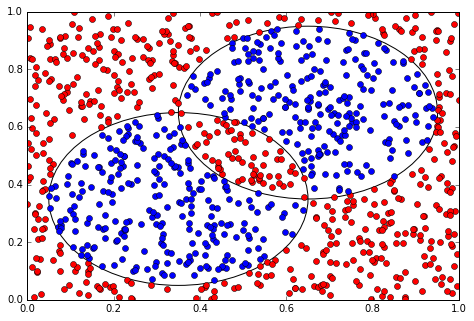

In [4]:
data0 = data[data[:,2]==0]
data1 = data[data[:,2]==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "ro")
plt.plot(data1[:,0], data1[:,1], "bo")

## AdaBoost

In [5]:
X = data[:,0:2]; Y = data[:, 2]

In [6]:
def sigmoid(x):                                        
    return 1 / (1 + np.exp(-x))

In [7]:
# @np.vectorize
# def staircase01(x):
#     return 1.0 if x >= 0 else 0.0
# ↑意外と遅い
def staircase01(x):
    return np.round(sigmoid(x))

In [8]:
def weakLearn(X, Y, D):
    e = 1.0
    X1 = np.hstack((X, np.ones((np.size(X, 0), 1))))
    W = np.random.rand(1000, 3) * 2 - 1
    wx = staircase01(np.dot(W, X1.T))
    es = np.dot(np.abs(wx-Y), D)
    # for e>=0.5
    W = np.vstack((W[es<0.5], -W[es>=0.5]))
    wx = np.vstack((wx[es<0.5], 1-wx[es>=0.5]))
    es = np.dot(np.abs(wx-Y), D)
    idx = es.argmin()
    w = W[idx, :]
    h = lambda x: staircase01(np.dot(x, w[0:2]) + w[2])
    e = np.dot(np.abs(h(X)-Y), D)
    return (h, e)

In [9]:
def adaboost(X, Y, weakLearn=weakLearn, T=100):
    M = np.size(Y)
    D = np.ones(M) / M
    hs = []
    alpha = []
    for t in range(T):
        h, e = weakLearn(X, Y, D)
        if e < 1e-10: break
        a = np.log((1 - e) / e) / 2
        D *= np.exp(a * ((Y + h(X)) % 2 * 2 - 1))
        D /= np.sum(D)
        hs.append(h)
        alpha.append(a)
    return lambda x: staircase01(np.dot(alpha, np.array([h(x) for h in hs])*2-1))

In [10]:
H = adaboost(X, Y)

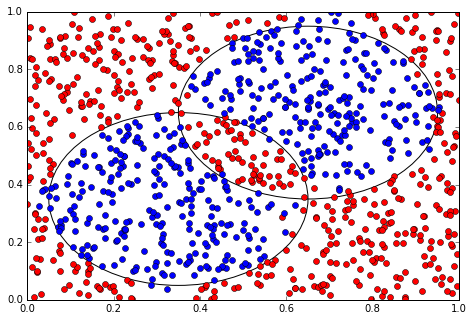

In [11]:
Yd = H(X)
data0 = X[Yd==0]
data1 = X[Yd==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "ro")
plt.plot(data1[:,0], data1[:,1], "bo")


In [12]:
tp = np.sum(Y[Yd==1])
fp = np.sum(1-Y[Yd==1])
tn = np.sum(1-Y[Yd==0])
fn = np.sum(Y[Yd==0])
np.array([[tp,fp],[fn,tn]])

array([[ 472.,   19.],
       [  10.,  499.]])

In [13]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
print("accuracy: %.06f" % accuracy)

accuracy: 0.971000


In [14]:
precision = tp / (tp + fp)
print("precision: %.06f" % precision)

precision: 0.961303


In [15]:
recall = tp / (tp + fn)
print("recall: %.06f" % recall)

recall: 0.979253


In [16]:
f_measure = 2 * precision * recall / (precision + recall)
print("f_measure: %.06f" % f_measure)

f_measure: 0.970195


In [17]:
x_test = np.random.rand(100, 2)
y_test = H(x_test)

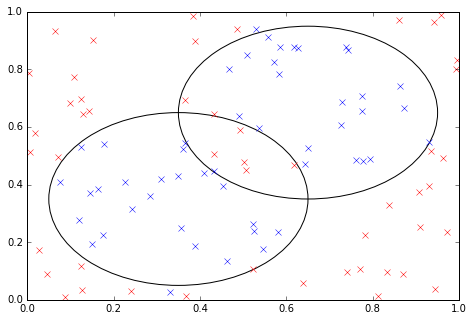

In [18]:
data0 = x_test[y_test==0]
data1 = x_test[y_test==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "rx")
plt.plot(data1[:,0], data1[:,1], "bx")

### Another WeakLearn Fn

In [19]:
def weakLearn2(X, Y, D):
    def mkMat(X):
        N = np.size(X, 0)
        return np.hstack((X, X**2, np.sum(X, axis=1).reshape(N, 1), np.ones((N, 1))))
    e = 1.0
    X1 = mkMat(X)
    W = np.random.rand(1000, 6) * 2 - 1
    wx = staircase01(np.dot(W, X1.T))
    es = np.dot(np.abs(wx-Y), D)
    # for e>=0.5
    W = np.vstack((W[es<0.5], -W[es>=0.5]))
    wx = np.vstack((wx[es<0.5], 1-wx[es>=0.5]))
    es = np.dot(np.abs(wx-Y), D)
    idx = es.argmin()
    w = W[idx, :]
    h = lambda x: staircase01(np.dot(mkMat(x), w))
    e = np.dot(np.abs(h(X)-Y), D)
    return (h, e)

In [20]:
H2 = adaboost(X, Y, weakLearn=weakLearn2)

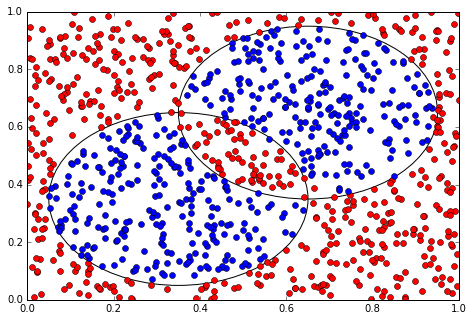

In [21]:
Yd2 = H2(X)
data0 = X[Yd2==0]
data1 = X[Yd2==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "ro")
plt.plot(data1[:,0], data1[:,1], "bo")


In [22]:
tp = np.sum(Y[Yd2==1])
fp = np.sum(1-Y[Yd2==1])
tn = np.sum(1-Y[Yd2==0])
fn = np.sum(Y[Yd2==0])
np.array([[tp,fp],[fn,tn]])

array([[ 478.,    1.],
       [   4.,  517.]])

In [23]:
accuracy = (tp + tn) / (tp + fp + fn + tn)
print("accuracy: %.06f" % accuracy)

accuracy: 0.995000


In [24]:
precision = tp / (tp + fp)
print("precision: %.06f" % precision)

precision: 0.997912


In [25]:
recall = tp / (tp + fn)
print("recall: %.06f" % recall)

recall: 0.991701


In [26]:
f_measure = 2 * precision * recall / (precision + recall)
print("f_measure: %.06f" % f_measure)

f_measure: 0.994797


In [27]:
x_test = np.random.rand(100, 2)
y_test = H2(x_test)

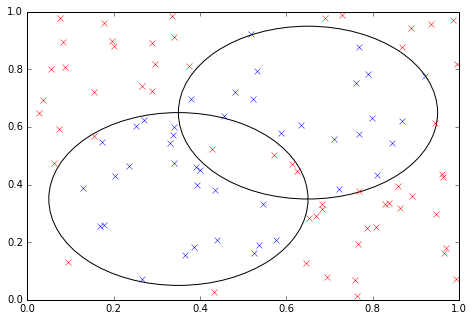

In [28]:
data0 = x_test[y_test==0]
data1 = x_test[y_test==1]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
c1 = plt.Circle((0.35, 0.35), 0.3, fill=False)
c2 = plt.Circle((0.65, 0.65), 0.3, fill=False)
ax.add_patch(c1)
ax.add_patch(c2)
plt.plot(data0[:,0], data0[:,1], "rx")
plt.plot(data1[:,0], data1[:,1], "bx")